<a href="https://colab.research.google.com/github/VladousSparrowous/LLM-interpretation/blob/main/Attention_Rollout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [125]:
from transformers import CLIPProcessor, CLIPModel, CLIPConfig
from PIL import Image
import requests
import torch
import matplotlib.pyplot as plt

config = CLIPConfig.from_pretrained("openai/clip-vit-base-patch32")
config.output_attentions = True
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", config=config)
model.eval()
model.vision_model.config.attention_mode = "eager"

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [66]:
from google.colab import files
files.upload('/root/.kaggle')

import os
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json



Saving kaggle.json to /root/.kaggle/kaggle (2).json
mv: cannot stat 'kaggle.json': No such file or directory


In [67]:
!kaggle datasets download -d hsankesara/flickr-image-dataset

Dataset URL: https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset
License(s): CC0-1.0
^C


In [68]:
import pandas as pd

df = pd.read_csv("/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv", sep="|")
df.head()

image_name  comment_number  \
0  1000092795.jpg               0   
1  1000092795.jpg               1   
2  1000092795.jpg               2   
3  1000092795.jpg               3   
4  1000092795.jpg               4   

                                             comment  
0   Two young guys with shaggy hair look at their...  
1   Two young , White males are outside near many...  
2   Two men in green shirts are standing in a yard .  
3       A man in a blue shirt standing in a garden .  
4            Two friends enjoy time spent together .

In [69]:
df.columns

Index(['image_name', ' comment_number', ' comment'], dtype='object')

In [70]:
num_samples=8
image_folder = '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images'
random_state=42

sample_df = df.sample(n=num_samples, random_state=random_state)
sample_df

image_name  comment_number  \
0  5797756884.jpg               2   
1   109260218.jpg               0   
2  5087543347.jpg               4   
3   450596617.jpg               4   
4   226481576.jpg               2   
5  5214515583.jpg               0   
6  2643263887.jpg               1   
7   369567283.jpg               1   

                                             comment  
0   A man is sitting on an upturned white bucket ...  
1   Spelunkers pose inside a rock cavern while ba...  
2             A toddler enjoying her birthday cake .  
3              Two people are walking by the ocean .  
4   Young , smiling , blond female police officer...  
5   Three men wearing leather apparel performing ...  
6   A child reaches the bottom of an inflatable s...  
7   A woman getting a styling cut from a female h...

In [144]:
# добавление разных текстов для изображения человека с гитарой

sample_df = pd.concat([sample_df[sample_df['image_name'] != '5797756884.jpg'], df[df['image_name'] == '5797756884.jpg']]).reset_index(drop=True)
num_samples=sample_df.shape[0]
sample_df

image_name  comment_number  \
0    109260218.jpg               0   
1   5087543347.jpg               4   
2    450596617.jpg               4   
3    226481576.jpg               2   
4   5214515583.jpg               0   
5   2643263887.jpg               1   
6    369567283.jpg               1   
7   5797756884.jpg               0   
8   5797756884.jpg               1   
9   5797756884.jpg               2   
10  5797756884.jpg               3   
11  5797756884.jpg               4   

                                              comment  
0    Spelunkers pose inside a rock cavern while ba...  
1              A toddler enjoying her birthday cake .  
2               Two people are walking by the ocean .  
3    Young , smiling , blond female police officer...  
4    Three men wearing leather apparel performing ...  
5    A child reaches the bottom of an inflatable s...  
6    A woman getting a styling cut from a female h...  
7    A man playing a banjo during street fair , ca...  
8    A man with a goatee panhandling by playing th...  
9    A man is sitting on an upturned white bucket ...  
10   A guy sitting outside on top of a bucket play...  
11   A man plays music on a banjo , in front of a ...

In [146]:
# @title Cosine similarity

from sklearn.metrics.pairwise import cosine_similarity

images = []
texts = []

for i, row in sample_df.iterrows():
    image_path = os.path.join(image_folder, row['image_name'])
    image = Image.open(image_path).convert("RGB")

    images.append(image)
    texts.append(row[' comment'])

inputs = processor(text=texts, images=images, return_tensors="pt", padding=True).to(device)

with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

image_embeds = outputs.image_embeds
text_embeds = outputs.text_embeds

image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)
text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)

scores = cosine_similarity(image_embeds.cpu().numpy(), text_embeds.cpu().numpy())
diagonal_scores = [scores[i][i] for i in range(len(scores))]

results = list(zip(images, texts, diagonal_scores))

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


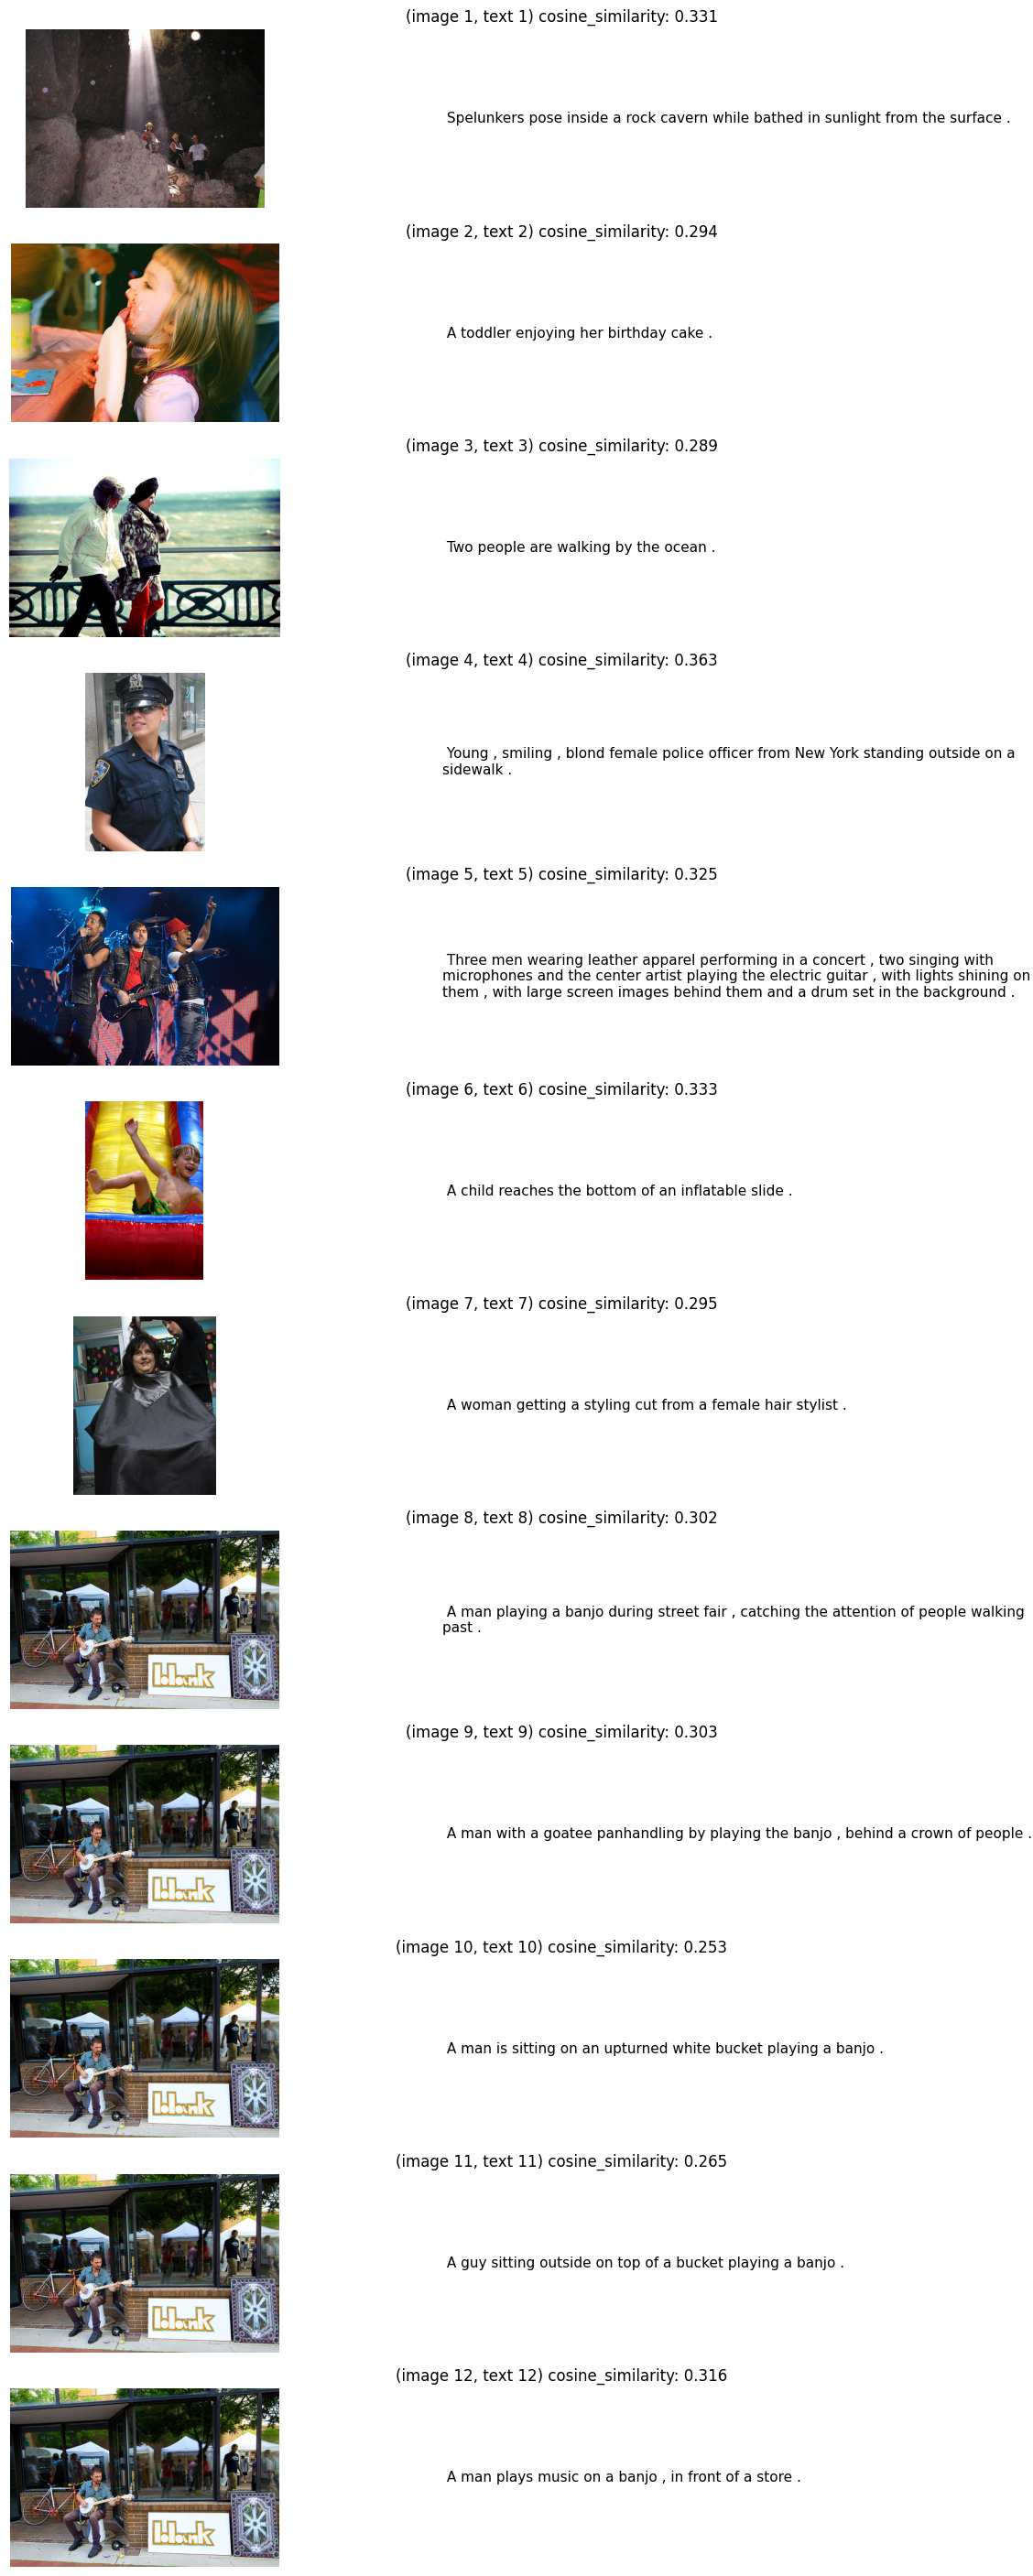

In [147]:
from matplotlib import gridspec


fig = plt.figure(figsize=(14, 3 * num_samples), constrained_layout=True)
gs = gridspec.GridSpec(num_samples, 3, width_ratios=[3, 1.5 , 1])

for i, (image, text, score) in enumerate(results):

    ax_img = plt.subplot(gs[i, 0])
    ax_img.imshow(image)
    ax_img.axis('off')


    ax_txt = plt.subplot(gs[i, 1])
    ax_txt.text(0, 0.5, text, fontsize=11, wrap=True, va='center')
    ax_txt.axis('off')

    plt.title(f"(image {i + 1}, text {i + 1}) cosine_similarity: {score:.3f}")

plt.show()

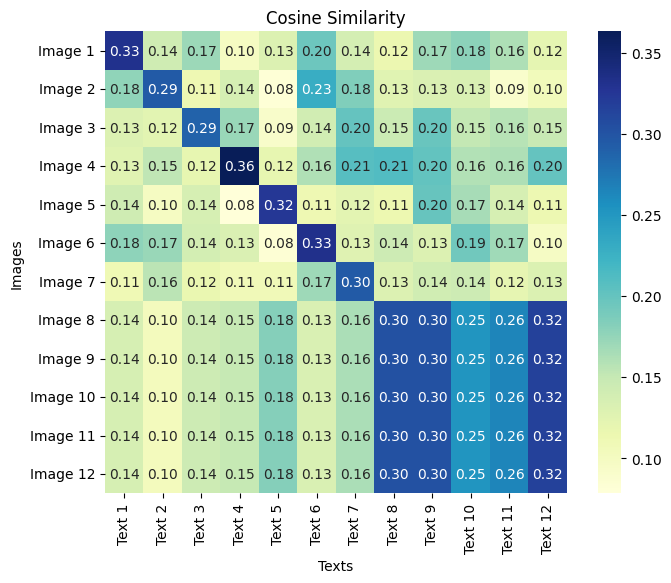

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))
sns.heatmap(scores, annot=True, fmt=".2f", cmap="YlGnBu", square=True,
            xticklabels=[f'Text {i + 1}' for i in range(len(scores))],
            yticklabels=[f'Image {i + 1}' for i in range(len(scores))])
plt.title("Cosine Similarity")
plt.xlabel("Texts")
plt.ylabel("Images")
plt.show()


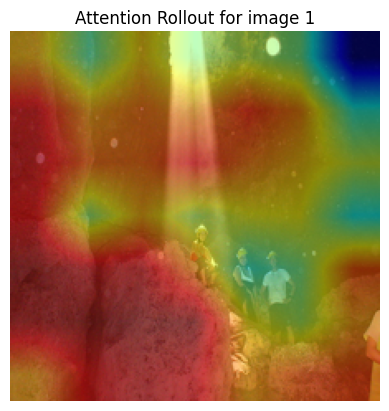

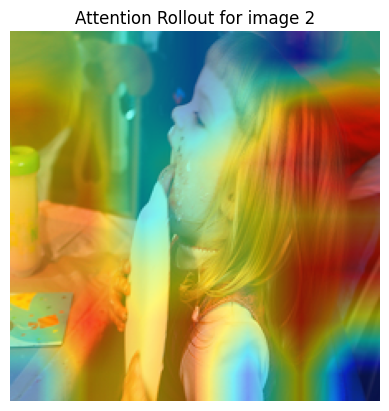

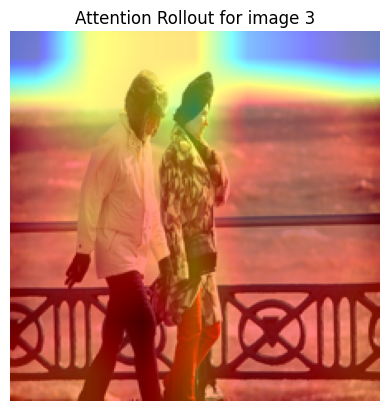

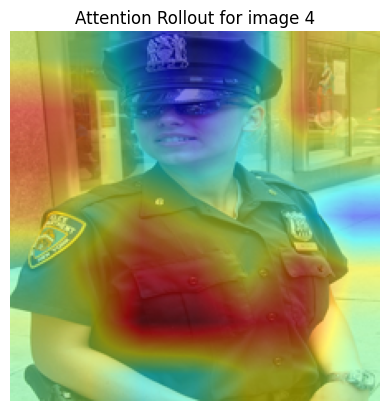

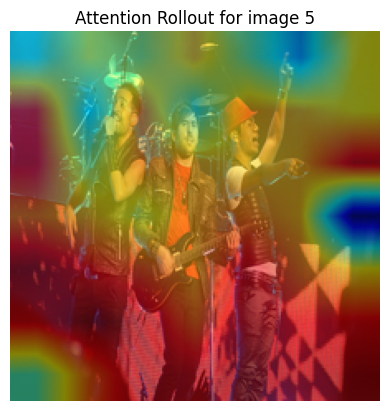

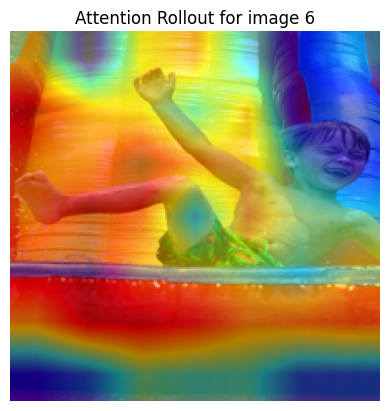

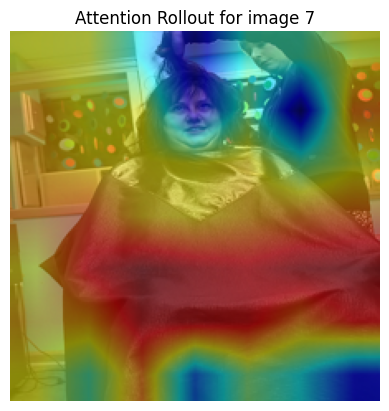

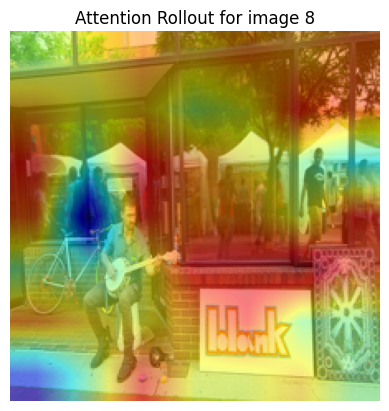

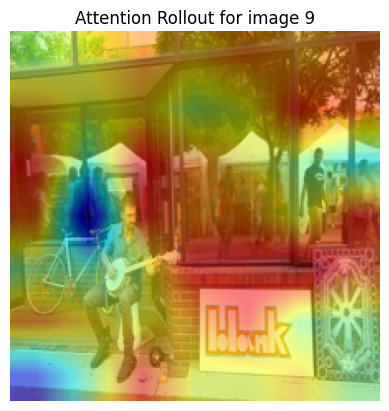

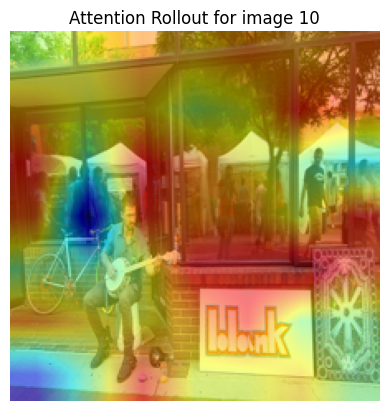

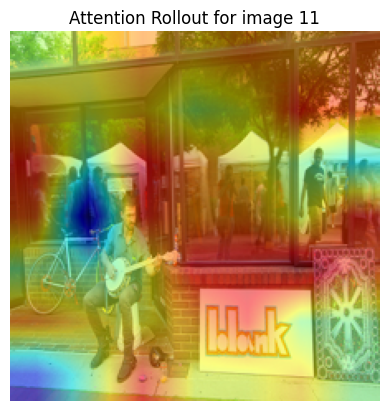

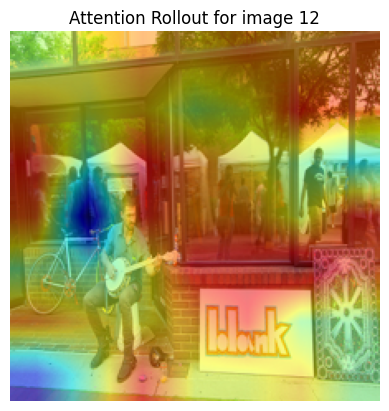

In [152]:
# @title Attention Rollout

import cv2

attentions = outputs.vision_model_output.attentions

def compute_attention_rollout(attentions):

    attn_mat = torch.stack(attentions).mean(dim=2)

    residual_att = []

    for layer_attention in attn_mat:
        batch_size, seq_len, _ = layer_attention.size()

        identity = torch.eye(seq_len).to(layer_attention.device)
        attn_with_residual = layer_attention + identity
        attn_with_residual /= attn_with_residual.sum(dim=-1, keepdim=True)
        residual_att.append(attn_with_residual)

    rollout = residual_att[0]
    for i in range(1, len(residual_att)):
        rollout = torch.bmm(residual_att[i], rollout)

    return rollout


rollout = compute_attention_rollout(attentions)

cls_attention = rollout[:, 0, 1:]

# Visualize attention map
def show_attention_on_image(img, num, attention, patch_size=32):

    image_np = np.array(img.resize((224, 224))) / 255.0
    height, width, _ = image_np.shape
    num_patches = int((height / patch_size) ** 2)
    attention = attention.reshape(1, 7, 7).detach().cpu().numpy()

    attention = cv2.resize(attention[0], (224, 224))
    attention = (attention - attention.min()) / (attention.max() - attention.min())

    heatmap = cv2.applyColorMap(np.uint8(255 * attention), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + image_np
    cam = cam / cam.max()

    plt.imshow(cam)
    plt.axis('off')
    plt.title(f"Attention Rollout for image {num}")
    plt.show()


for i, image in enumerate(images):
    show_attention_on_image(image,i+1 ,cls_attention[i])

# анализ

Для некоторых изображений, например для 4 го понятной, у этого изображения и косинусное сходсво с текстом наибольшее что, так же кажется разумнным, а у 8го не приходится на казалось бы самые информативные области.


интересно что для человека с гитарой наиболее схожий текст включает магазин что можно связать с большим вниманием модели к зданию нежели самому человеку